In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Multi-layer Perceptrons (MLP)

Multi-layer perceptrons have the form:

$$
f(x) = g^{(L)}(W^{(L)}g^{(L-1)}(W^{(L-1)}\ldots g^{(1)}(W^{(1)}x + b^{(1)}) + b^{(L-1)}) + b^{(L)})
$$

where $x$ is the input, $W^{(l)}$ and $b^{(l)}$ are the weights and biases of the $l$-th layer, and $g^{(l)}$ is the activation function of the $l$-th layer.

For PINNS applications, it is recommended that:
+ We use the tanh activation function all layers.
+ We use 128 to 512 neurons per layer.
+ We use 3 to 5 layers.
+ Use the Glorot initialization (this is the default in `equinox`).

Let's implement a standard MLP in `equinox`:

In [65]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrandom


class MLP(eqx.Module):
    layers: list

    def __init__(self, dims, key):
        num_layers = len(dims) - 1
        keys = jrandom.split(key, num_layers)
        self.layers = [
            eqx.nn.Linear(dims[i], dims[i+1], key=k)
            for i, k in enumerate(keys)
        ]
        
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jnp.tanh(layer(x))
        return self.layers[-1](x)[0]

We are going to solve a Poisson's equation with a source term:

$$
\begin{aligned}
    -\nabla^2 u(x, y) &= f(x, y) \quad \text{in} \quad \Omega = [0, 1]^2, \\
    u(x, y) &= 0 \quad \text{on} \quad \partial \Omega.
\end{aligned}
$$

We will use a common trick to construct an exact solution. We will use the following function:

$$
u(x, y) = \sin(\pi x) \sin(\pi y).
$$

The boundary conditions are satisfied by construction. The source term is:

In [88]:
import sympy
x, y = sympy.symbols('x y')

u = sympy.sin(sympy.pi * x) * sympy.sin(sympy.pi * y)
f = -sympy.diff(u, x, 2) + sympy.diff(u, y, 2)
f

0

This is a common trick for constructing exact solutions. Remember it!

We are going to solve this boundary value problem using PINNS.
Our model will be:

$$
u(x,y) = x(1-x)y(1-y)\text{MLP}(x, y),
$$

where $\text{MLP}(x, y)$ is a multi-layer perceptron, and $x(1-x)y(1-y)$ is a polynomial that satisfies the boundary conditions.
This is also a common trick for enforcing boundary conditions in PINNS.

Let's make the model:

In [66]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
mlp = MLP([2, 128, 128, 128, 1], key)
u_hat = lambda x, y, mlp: x * (1 - x) * y * (1 - y) * mlp(jnp.array([x, y]))

Let's see how it looks like before we train it:

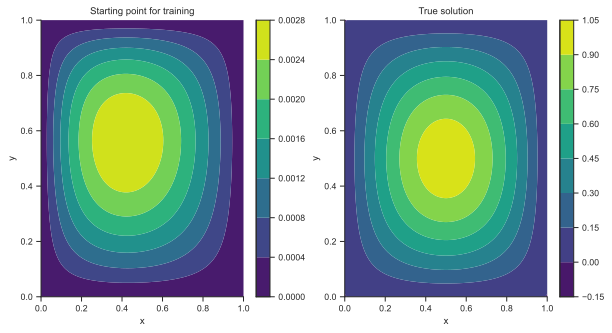

In [82]:
from jax import vmap

v_u_hat = eqx.filter_jit(vmap(u_hat, in_axes=(0, 0, None)))

x = jnp.linspace(0, 1, 100)
X, Y = jnp.meshgrid(x, x)
u_pred = v_u_hat(X.flatten(), Y.flatten(), mlp).reshape(X.shape)

# the true solution for comparison
u_true = jnp.sin(jnp.pi * X) * jnp.sin(jnp.pi * Y)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Starting point for training')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('True solution')
sns.despine(trim=True);

We are going to train this by minimizing the following loss function:

$$
\mathcal{L}(\theta) = \int_{\Omega} \left( \nabla^2 u(x, y) + f(x, y) \right)^2 \, dx \, dy.
$$

The first step, is to turn the loss function into an expectation.
Construct the random variable $\mathbf{X} = (X,Y)$ uniformly distributed in $\Omega$.
Then, the loss function can be written as:

$$
\mathcal{L}(\theta) = |\Omega|\mathbb{E}\left[ \left( \nabla^2 u(\mathbf{X}) + f(\mathbf{X}) \right)^2 \right].
$$

Notice that the volume of $\Omega$, $\Omega|$, appears as a constant factor.
Where did it come from?
Recall the probability density function of $\mathbf{X}$ is:

$$
p(\mathbf{x}) = \frac{1}{|\Omega|} \quad \text{if} \quad \mathbf{x} \in \Omega, \quad \text{and} \quad 0 \quad \text{otherwise}.
$$

So:

$$
\int_{\Omega} \left( \nabla^2 u(\mathbf{x}) + f(\mathbf{x}) \right)^2 \, d\mathbf{x}
= \int_{\Omega} \left( \nabla^2 u(\mathbf{x}) + f(\mathbf{x}) \right)^2 |\Omega|p(\mathbf{x}) \, d\mathbf{x}
= |\Omega|\mathbb{E}\left[ \left( \nabla^2 u(\mathbf{X}) + f(\mathbf{X}) \right)^2 \right].
$$

We can approximate this expectation by sampling a finite number of points from $\Omega$ and averaging the loss function over these points.
This is what we will be doing in each iteration of the training process.

In [89]:
from jax import grad

# First order derivatives
u_x = grad(u_hat, argnums=0)
u_y = grad(u_hat, argnums=1)

# Second order deerivatives
u_xx = grad(u_x, argnums=0)
u_yy = grad(u_y, argnums=1)

# The Laplacian
D2_u = lambda x, y, mlp: u_xx(x, y, mlp) + u_yy(x, y, mlp)

# The source term
source_term = lambda x, y: 2 * jnp.pi ** 2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

# The PDE residual (vectorize)
pde_residual = vmap(
    lambda x, y, mlp: laplacian_u_hat(x, y, mlp) + source_term(x, y),
    in_axes=(0, 0, None))

# Finally the loss function:
loss = lambda mlp, x, y: jnp.mean(jnp.square(pde_residual(x, y, mlp)))

The training loop:

In [108]:
import optax


def train(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
        freq=1,
    ):

    @eqx.filter_jit
    def step(opt_state, mlp, xs, ys):
        value, grads = eqx.filter_value_and_grad(loss)(mlp, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state, value
    
    opt_state = optimizer.init(mlp)
    losses = []
    for i in range(num_iter):
        key, subkey = jrandom.split(key)
        xb = jrandom.uniform(subkey, (num_collocation_residual,))
        key, subkey = jrandom.split(key)
        yb = jrandom.uniform(subkey, (num_collocation_residual,))
        mlp, opt_state, value = step(opt_state, mlp, xb, yb)
        if i % freq == 0:
            losses.append(value)
            print(f"Step {i}, residual loss {value:.3e}")
    return mlp, losses

In [114]:
optimizer = optax.adam(1e-3)
trained_mlp, losses = train(mlp, key, optimizer, num_collocation_residual=256, num_iter=2_000, freq=100)

Step 0, residual loss 1.618e+02
Step 100, residual loss 1.302e+01
Step 200, residual loss 7.636e+00
Step 300, residual loss 1.028e+01
Step 400, residual loss 2.339e+00
Step 500, residual loss 3.037e-02
Step 600, residual loss 8.026e-03
Step 700, residual loss 1.483e-02
Step 800, residual loss 3.946e-03
Step 900, residual loss 3.091e-03
Step 1000, residual loss 1.993e-03
Step 1100, residual loss 1.273e-03
Step 1200, residual loss 1.265e-03
Step 1300, residual loss 2.487e-03
Step 1400, residual loss 2.451e-03
Step 1500, residual loss 3.169e-03
Step 1600, residual loss 8.282e-04
Step 1700, residual loss 1.734e-03
Step 1800, residual loss 1.792e-03
Step 1900, residual loss 1.731e-03


Let's visualize first the evolution of the loss function:

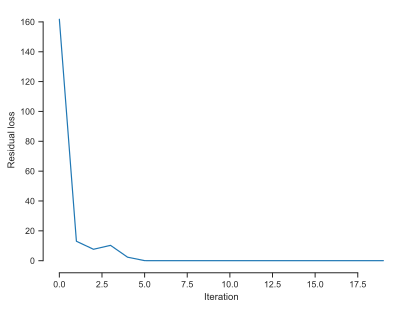

In [116]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Iteration')
ax.set_ylabel('Residual loss')
sns.despine(trim=True);

Let's visualize the solution:

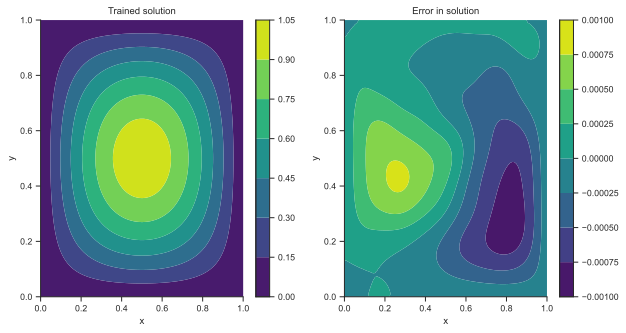

In [117]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);

Let's try to `jit` the entire training loop to see how much faster it runs.

In [110]:
from jax import lax

@eqx.filter_jit
def train_jit(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
    ):

    def step(opt_state, mlp, xs, ys):
        grads = eqx.filter_grad(loss)(mlp, xs, ys)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state
    
    opt_state = optimizer.init(mlp)
    init_val = (key, mlp, opt_state)
    def body_fun(i, val):
        key, mlp, opt_state = val
        key, subkey = jrandom.split(key)
        xb = jrandom.uniform(subkey, (num_collocation_residual,))
        key, subkey = jrandom.split(key)
        yb = jrandom.uniform(subkey, (num_collocation_residual,))
        mlp, opt_state = step(opt_state, mlp, xb, yb)
        return (key, mlp, opt_state)
    
    final_val = lax.fori_loop(0, num_iter, body_fun, init_val)
    return final_val[1]

In [132]:
trained_mlp = train_jit(mlp, key, optimizer, num_collocation_residual=256, num_iter=10_000)

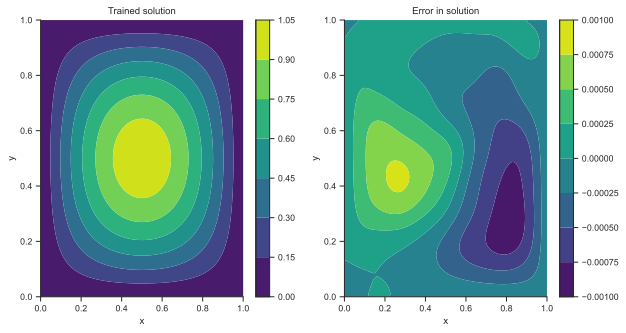

In [123]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);

Let's investigate another way to do it. We will generate the training data before training loop.

In [124]:
@eqx.filter_jit
def train_batch(
        mlp,
        key,
        optimizer,
        num_collocation_residual=512,
        num_iter=10_000,
    ):
    xs = jrandom.uniform(key, (num_iter, num_collocation_residual, 2))
    
    def step(opt_state, mlp, xb, yb):
        value, grads = eqx.filter_value_and_grad(loss)(mlp, xb, yb)
        updates, opt_state = optimizer.update(grads, opt_state)
        mlp = eqx.apply_updates(mlp, updates)
        return mlp, opt_state, value
    
    opt_state = optimizer.init(mlp)
    init = (opt_state, mlp)
    def f(carry, x):
        opt_state, mlp = carry
        xb, yb = x[:, 0], x[:, 1]
        mlp, opt_state, value = step(opt_state, mlp, xb, yb)
        return (opt_state, mlp), value
    
    (opt_state, mlp), losses = lax.scan(f, init, xs)
    return mlp, losses

In [130]:
trained_mlp, losses = train_batch(mlp, key, optimizer, num_collocation_residual=256, num_iter=10_000)

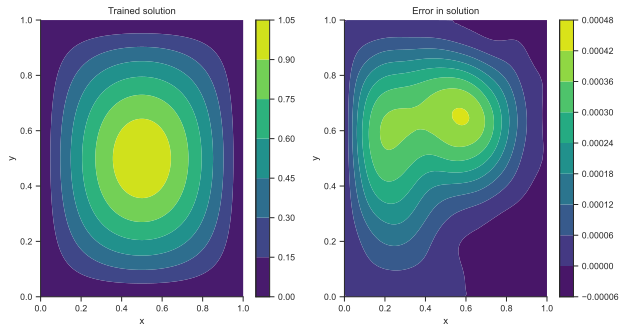

In [131]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
u_pred = v_u_hat(X.flatten(), Y.flatten(), trained_mlp).reshape(X.shape)
c = ax[0].contourf(X, Y, u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title('Trained solution')
sns.despine(trim=True);
c = ax[1].contourf(X, Y, u_true - u_pred, cmap='viridis')
fig.colorbar(c, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Error in solution')
sns.despine(trim=True);